In [48]:
import sys
import os
sys.path.insert(0, '../../Utilities/')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io

# Physics-Informed Neural Networks (PINNs)

## Введение

Физически-информированные нейронные сети (PINNs) — это метод, который использует нейронные сети для решения дифференциальных уравнений. Основная идея состоит в том, чтобы обучить сеть на основе данных и уравнений, чтобы предсказать поведение физических систем.

## Уравнения

1. **Функция потерь**:
        L= N1​i=1∑N​(u 0true​−u 0pred​) 
   где:
   - \( L \) — функция потерь (MSE).
   - \( u_0^{true} \) — истинные значения.
   - \( u_0^{pred} \) — предсказанные значения.

2. **Активационная функция**:
   a=tanh(z)
   где \( z \) — линейная комбинация входных данных и весов.

## Алгоритм обучения

1. Инициализация весов и смещений.
2. Прямой проход через сеть.
3. Вычисление функции потерь.
4. Численное вычисление градиентов.
5. Обновление весов и смещений с использованием градиентного спуска.

## Заключение

PINNs позволяют эффективно моделировать и предсказывать поведение сложных систем, используя комбинацию данных и физических принципов.


In [49]:
import numpy as np

class PhysicsInformedNN:
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):
        """
        Инициализация параметров сети.
        
        :param x0: Входные данные для U0 (начальные условия).
        :param u0: Целевые выходные данные для U0.
        :param x1: Входные данные для U1 (не используются в функции потерь).
        :param layers: Конфигурация слоев нейронной сети.
        :param dt: Временной шаг (не используется в текущей реализации).
        :param lb: Нижние границы входных данных (не используются).
        :param ub: Верхние границы входных данных (не используются).
        :param q: Дополнительный параметр (не используется).
        """
        # Инициализация параметров
        self.x0 = x0  # Входные данные для U0
        self.u0 = u0  # Целевые выходные данные для U0
        self.x1 = x1  # Входные данные для U1 (не используются в функции потерь)
        self.layers = layers  # Конфигурация слоев
        self.dt = dt
        self.lb = lb
        self.ub = ub
        self.q = q

        # Инициализация весов и смещений
        self.weights = [np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i]) for i in range(len(layers) - 1)]
        self.biases = [np.random.randn(layers[i + 1]) for i in range(len(layers) - 1)]

    def initialize_NN(self, layers):
        """
        Инициализация весов и смещений для нейронной сети.
        
        :param layers: Конфигурация слоев.
        :return: Кортеж весов и смещений.
        """
        weights = []
        biases = []
        for l in range(len(layers) - 1):
            weights.append(np.random.randn(layers[l], layers[l + 1]) * np.sqrt(2.0 / layers[l]))  # Инициализация Хе
            biases.append(np.zeros((1, layers[l + 1])))
        return weights, biases

    def forward(self, x):
        """
        Прямой проход через сеть (feedforward).
        
        :param x: Входные данные.
        :return: Выходные данные сети.
        """
        a = x
        for i in range(len(self.weights)):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = np.tanh(z)  # Функция активации (можно изменить)
        return a

    def predict(self, x):
        """
        Прогнозирование на основе обученной модели.
        
        :param x: Входные данные.
        :return: Предсказания модели.
        """
        return self.forward(x)

    def _tanh(self, x):
        """
        Функция активации tanh.
        
        :param x: Входные данные.
        :return: Выходные данные после применения функции tanh.
        """
        return np.tanh(x)

    def net_U0(self, x):
        """
        Вычисление предсказаний U0.
        
        :param x: Входные данные.
        :return: Предсказания U0.
        """
        return self.forward(x)  # Предполагается один выход из сети

    def loss_function(self):
        """
        Вычисление функции потерь.
        
        :return: Значение функции потерь.
        """
        U0_pred = self.net_U0(self.x0)  # Вычисление предсказаний U0
        loss_U0 = np.mean((self.u0 - U0_pred) ** 2)  # Вычисление потерь MSE
        return loss_U0

    def train(self, nIter):
        """
        Обучение  мат модели.
        Вычисление градиентов прохождение по весам
        
        :param nIter: Количество итераций обучения.
        """
        for it in range(nIter):
            # Вычисление потерь
            loss = self.loss_function()
    
            # Инициализация градиентов
            grad_weights = [np.zeros_like(w) for w in self.weights]
            grad_biases = [np.zeros_like(b) for b in self.biases]
    
            # Численное вычисление градиента
            epsilon = 1e-6
    
            # Вычисление градиентов для весов
            for i in range(len(self.weights)):
                weight_shape = self.weights[i].shape
    
                for idx in range(weight_shape[0]):  # Проход по первому измерению
                    for jdx in range(weight_shape[1]):  # Проход по второму измерению
                        # Возмущение веса
                        original_weight = self.weights[i][idx, jdx]
    
                        self.weights[i][idx, jdx] += epsilon
                        loss_plus = self.loss_function()
    
                        self.weights[i][idx, jdx] = original_weight - epsilon
                        loss_minus = self.loss_function()
    
                        # Вычисление градиента
                        grad_weights[i][idx, jdx] = (loss_plus - loss_minus) / (2 * epsilon)
    
                        # Восстановление оригинального веса
                        self.weights[i][idx, jdx] = original_weight
    
            # Вычисление градиентов для смещений
            for i in range(len(self.biases)):
                bias_shape = self.biases[i].shape
    
                for idx in range(bias_shape[0]):  # Проход по измерению смещения
                    original_bias = self.biases[i][idx]
    
                    self.biases[i][idx] += epsilon
                    loss_plus = self.loss_function()
    
                    self.biases[i][idx] = original_bias - epsilon
                    loss_minus = self.loss_function()
    
                    # Вычисление градиента
                    grad_biases[i][idx] = (loss_plus - loss_minus) / (2 * epsilon)
    
                    # Восстановление оригинального смещения
                    self.biases[i][idx] = original_bias
    
            # Обновление весов и смещений с использованием градиентного спуска
            learning_rate = 0.001
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * grad_weights[i]
                self.biases[i] -= learning_rate * grad_biases[i]
    
            # Печать потерь каждые 10 итераций
            if it % 10 ** 3 == 0:  # Можно изменить на 10 или 20 для лучшего наблюдения
                print(f"Итерация {it}, Потери: {loss}")


In [50]:
# Data loading and initial parameter setup
print(os.getcwd())

# Load the data from the .mat file
data = scipy.io.loadmat('AC.mat')

# Extract the necessary variables
t = data['tt'].flatten()[:, None]  # Time values
x = data['x'].flatten()[:, None]   # Spatial values
Exact = np.real(data['uu']).T      # Real part of 'uu', transposed for correct shape

# Select indices for initialization
idx_t0 = 20
idx_t1 = 180

iterations = 10 ** 5   # Example value for iterations

# Initialize data
N = 100  # Number of spatial points to select
idx_x = np.random.choice(Exact.shape[1], N, replace=False)  # Randomly select N points

x0 = x[idx_x, :]  # Spatial points at t0
u0 = Exact[idx_t0:idx_t0+1, idx_x].T  # Corresponding initial condition data

# Boundary conditions
lb = x.min()  # Lower boundary (min value of x) 
ub = x.max()  # Upper boundary (max value of x)

# Create the model and train it
layers = [1, 20, 20, 1]  # Example layer structure
dt = 0.01  # Example time step
q = None  # Placeholder for q, define as needed

model = PhysicsInformedNN(x0, u0, x, layers, dt, lb, ub, q)

# Train the model
model.train(iterations)  # Training for specified iterations

# Make predictions after training
x_star = x  # Assuming we want predictions over all x points
U1_pred = model.predict(x_star)  # Make predictions using the trained model

C:\Users\77003\JupyterLab\PINN_course\HW_2
Итерация 0, Потери: 0.9912924192640287
Итерация 1000, Потери: 0.03628043053002432
Итерация 2000, Потери: 0.03335881586239792
Итерация 3000, Потери: 0.031000074859326526
Итерация 4000, Потери: 0.028783602871770272
Итерация 5000, Потери: 0.026673098348893098
Итерация 6000, Потери: 0.024671843712996723
Итерация 7000, Потери: 0.022786833663189735
Итерация 8000, Потери: 0.02102365262533723
Итерация 9000, Потери: 0.019385175129608825
Итерация 10000, Потери: 0.017871276728934446
Итерация 11000, Потери: 0.016479123359739972
Итерация 12000, Потери: 0.015203773802966647
Итерация 13000, Потери: 0.014038865356920241
Итерация 14000, Потери: 0.01297723093166264
Итерация 15000, Потери: 0.012011380099492193
Итерация 16000, Потери: 0.011133836406839175
Итерация 17000, Потери: 0.010337353340420836
Итерация 18000, Потери: 0.009615040038483092
Итерация 19000, Потери: 0.008960425355950959
Итерация 20000, Потери: 0.008367482461135672
Итерация 21000, Потери: 0.00783

C:\Users\77003\AppData\Local\Temp\ipykernel_20304\1196820904.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
C:\Users\77003\AppData\Local\Temp\ipykernel_20304\1196820904.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax2.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)


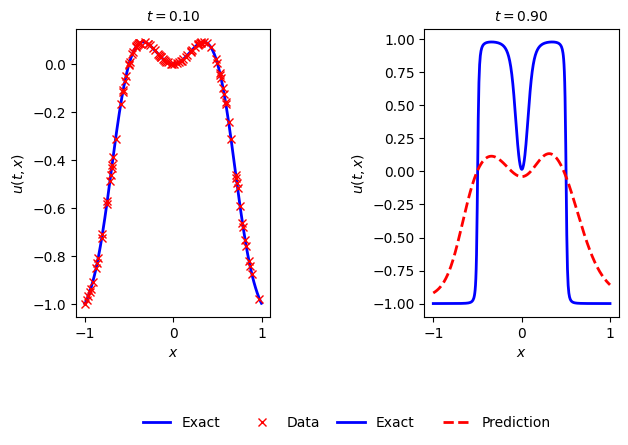

In [51]:
# Plotting the results
import matplotlib.gridspec as gridspec

# Define the grid for subplots
gs1 = gridspec.GridSpec(1, 2)

# First plot at time t0
ax1 = plt.subplot(gs1[0, 0])
ax1.plot(x, Exact[idx_t0, :], 'b-', linewidth=2, label='Exact')  # Exact solution at t0
ax1.plot(x0, u0, 'rx', linewidth=2, label='Data')  # Initial condition
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
ax1.set_xlim([lb - 0.1, ub + 0.1])
ax1.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)

# Second plot at time t1
ax2 = plt.subplot(gs1[0, 1])
ax2.plot(x, Exact[idx_t1, :], 'b-', linewidth=2, label='Exact')  # Exact solution at t1
ax2.plot(x_star, U1_pred, 'r--', linewidth=2, label='Prediction')  # Predicted solution
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u(t, x)$')
ax2.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)
ax2.set_xlim([lb - 0.1, ub + 0.1])
ax2.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

# Display the plots
plt.tight_layout()
plt.show()